<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [1]:
#from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
#import warnings
#warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'w3data'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
from more_itertools import windowed
from datetime import datetime, timedelta


def prepare_train_set_with_fe(
    path_to_csv_files, site_freq_path, feature_names, session_length=10, window_size=10
):

    file_list = sorted(glob(os.path.join(path_to_csv_files, "user*.csv")))

    with open(site_freq_path, "rb") as file:
        fr_dict = pickle.load(file)

    dtfmt = "%Y-%m-%d %H:%M:%S"
    sessions = []
    for file_name in tqdm(file_list):
        user_id = int(os.path.basename(file_name)[len("user") : -len(".csv")])

        with open(file_name, "r") as file:
            file.readline()
            for fold in windowed(file, session_length, step=window_size):

                timestamps, sites = list(zip(*[rec[:-1].split(",") for rec in fold if rec]))

                # добавляем id сайтов
                sites = [fr_dict[site][0] for site in sites]
                session = sites + [0] * (session_length - len(sites))

                # добавляем tdiffs
                timestamps = [datetime.strptime(tsmp, dtfmt) for tsmp in timestamps]
                tdiffs = [int((a - b).total_seconds()) for a, b in zip(timestamps[1:], timestamps[:-1])]
                session += tdiffs + [0] * (session_length - 1 - len(tdiffs))

                # добавляем fe
                session.append(int((max(timestamps) - min(timestamps)).total_seconds()))
                session.append(len(set(sites)))
                session.append(min(timestamps).hour)
                session.append(min(timestamps).weekday())
                session.append(user_id)

                sessions.append(session)

    return pd.DataFrame(sessions, columns=feature_names)

**Проверим функцию на игрушечном примере.**

In [4]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,8,5,9,10,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [6]:
%%time
train_data_10users = prepare_train_set_with_fe(
    os.path.join(PATH_TO_DATA, "10users"),
    site_freq_path=os.path.join(PATH_TO_DATA, "site_freq_10users.pkl"),
    feature_names=feature_names,
    session_length=10,
)


CPU times: user 2.56 s, sys: 18.1 ms, total: 2.58 s
Wall time: 2.55 s


In [7]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,192,574,133,3,133,133,3,133,203,133,10,0,0,1,20,1,0,1,0,33,5,8,4,31
1,415,193,674,254,133,31,393,3305,217,55,1,0,163,105,0,1,3,3,8,284,10,8,4,31
2,55,3,55,55,5,293,415,333,897,55,0,14,1,242,0,0,1,0,0,258,7,8,4,31
3,473,3306,473,55,55,55,55,937,199,123,2,1,0,1,25,1,0,0,0,30,6,8,4,31
4,342,55,5,3307,258,211,3308,2086,675,2086,1,0,1,1,1,0,1,1,0,6,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [8]:
%%time
train_data_150users = prepare_train_set_with_fe(
    os.path.join(PATH_TO_DATA, "150users"),
    site_freq_path=os.path.join(PATH_TO_DATA, "site_freq_150users.pkl"),
    feature_names=feature_names,
    session_length=10,
)


CPU times: user 26.1 s, sys: 142 ms, total: 26.2 s
Wall time: 25.9 s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [9]:
new_features_10users = train_data_10users[["session_timespan", "#unique_sites", "start_hour", "day_of_week"]]
new_features_150users = train_data_150users[["session_timespan", "#unique_sites", "start_hour", "day_of_week"]]

In [10]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, для потехи дадим пользователям имена и ассоциируем с ними цвета.**

In [11]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [12]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

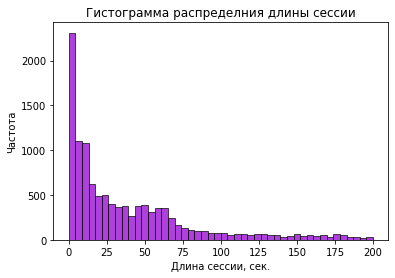

In [13]:
df = train_data_10users["session_timespan"]
ax = sns.histplot(df[df <= 200], kde=False, color="darkviolet")
ax.set_xlabel("Длина сессии, сек.")
ax.set_ylabel("Частота")
ax.set_title("Гистограмма распределния длины сессии")
plt.show()

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

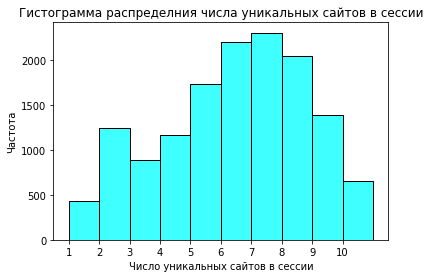

In [14]:
df = train_data_10users["#unique_sites"]
ax = sns.histplot(df, kde=False, color="aqua", bins=10, binrange=(1, 11))
ax.set_xticks(range(1,11))
ax.set_xlabel("Число уникальных сайтов в сессии")
ax.set_ylabel("Частота")
ax.set_title("Гистограмма распределния числа уникальных сайтов в сессии")
plt.show()

In [15]:
train_data_10users["#unique_sites"].value_counts()

7     2307
6     2199
8     2045
5     1735
9     1394
2     1249
4     1163
3      890
10     651
1      428
Name: #unique_sites, dtype: int64

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

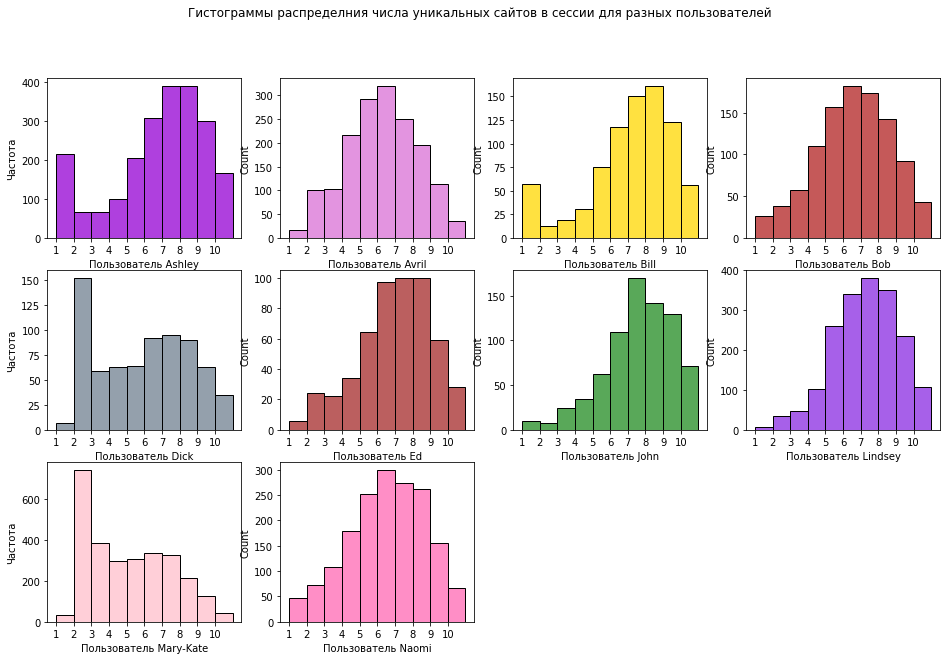

In [16]:
fig = plt.figure(figsize=(16, 10))
for idx, (user, sub_df) in enumerate(train_data_10users.groupby("target"), 1):
    plt.subplot(3, 4, idx)
    ax = sns.histplot(
        sub_df["#unique_sites"],
        kde=False,
        color=color_dic[user],
        bins=10,
        binrange = (1, 11),
    )
    ax.set_xticks(range(1,11))
    ax.set_xlabel(f"Пользователь {user}")
    if idx % 4 == 1:
        ax.set_ylabel("Частота")
fig.suptitle("Гистограммы распределния числа уникальных сайтов в сессии для разных пользователей")
plt.show()

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

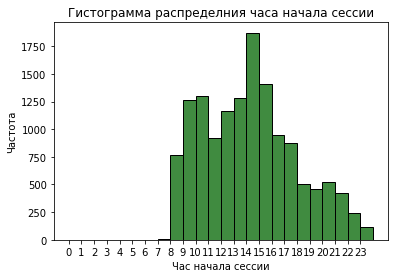

In [17]:
df = train_data_10users["start_hour"]
ax = sns.histplot(df, kde=False, color="darkgreen", bins=24, binrange=(0,24))
ax.set_xticks(range(24))
ax.set_xlabel("Час начала сессии")
ax.set_ylabel("Частота")
ax.set_title("Гистограмма распределния часа начала сессии")
plt.show()

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

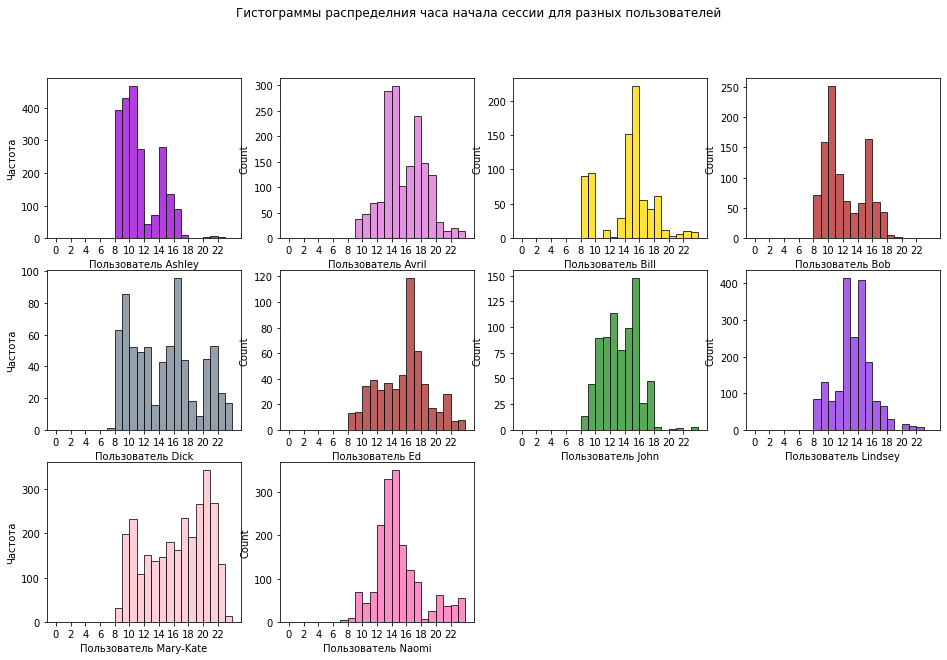

In [18]:
fig = plt.figure(figsize=(16, 10))
for idx, (user, sub_df) in enumerate(train_data_10users.groupby("target"), 1):
    plt.subplot(3, 4, idx)
    ax = sns.histplot(
        sub_df["start_hour"],
        kde=False,
        color=color_dic[user],
        bins=24,
        binrange = (0,24),
    )
    ax.set_xticks(range(0,24,2))
    ax.set_xlabel(f"Пользователь {user}")
    if idx % 4 == 1:
        ax.set_ylabel("Частота")
fig.suptitle("Гистограммы распределния часа начала сессии для разных пользователей")
plt.show()

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

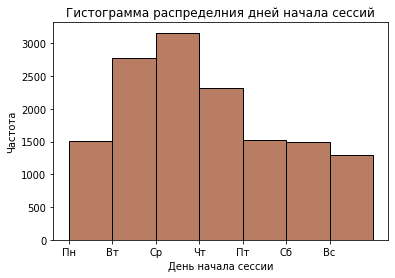

In [19]:
df = train_data_10users["day_of_week"]
ax = sns.histplot(df, kde=False, color="sienna", bins=7, binrange = (0, 7))
ax.set_xticks(range(7))
ax.set_xticklabels(["Пн","Вт","Ср","Чт","Пт","Сб","Вс"])
ax.set_xlabel("День начала сессии")
ax.set_ylabel("Частота")
ax.set_title("Гистограмма распределния дней начала сессий")

plt.show()

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

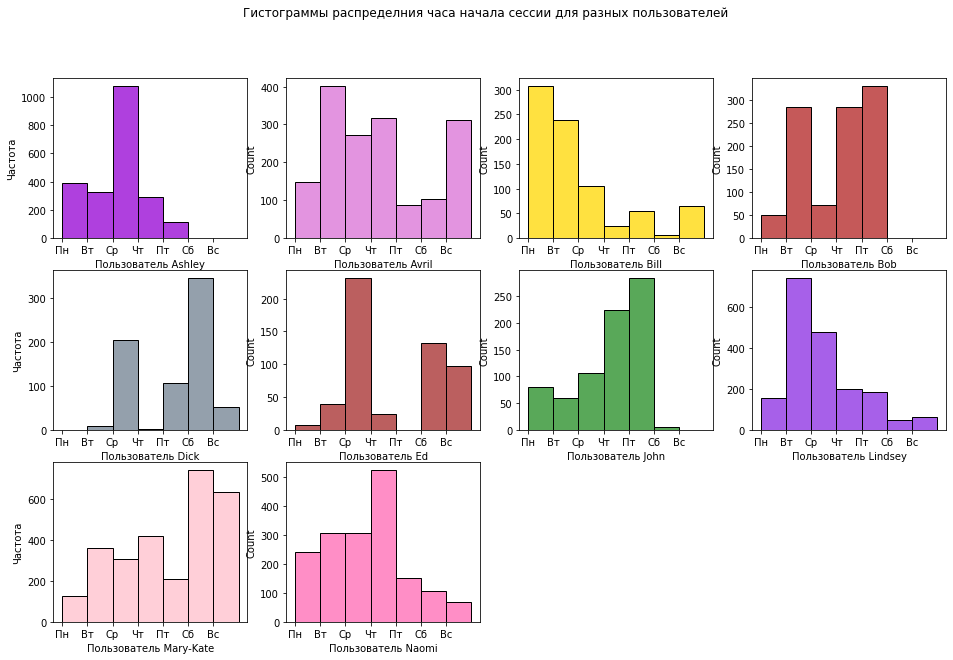

In [20]:
fig = plt.figure(figsize=(16, 10))
for idx, (user, sub_df) in enumerate(train_data_10users.groupby("target"), 1):
    plt.subplot(3, 4, idx)
    ax = sns.histplot(
        sub_df["day_of_week"],
        kde=False,
        color=color_dic[user],
        bins=7,
        binrange = (0,7),
    )
    ax.set_xticks(range(7))
    ax.set_xticklabels(["Пн","Вт","Ср","Чт","Пт","Сб","Вс"])
    ax.set_xlabel(f"Пользователь {user}")
    if idx % 4 == 1:
        ax.set_ylabel("Частота")
fig.suptitle("Гистограммы распределния часа начала сессии для разных пользователей")
plt.show()

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

> ### Решение

Относительно распределения **длины сессий**: видно что превалируют короткие сессии, и в общем вероятность длинны сессии снижается с ростом длины. При этом основной объём длин сессий сосредоточен на интервале от 0 до 100.


Относительно распределения **числа уникальных сессий**: в генеральной совокупности распределение бимодальное, первая мода равна 2, вторая равна 7. При этом вторая мода "тяжелее" первой. Таким образом сессии содержат как правило 2 или 6-7 уникальный сайтов, причём чаще - 6-7. 

В условных распределениях частоты по пользователям моды смещаются (у Ashley и Bill, например, первая мода смещается к 1, а у Bob и Naomi - вторая мода сдвигается к 6)  или исчезать (напр. у Avril и Ed нет первой моды, а у Mary-Kate -второй). Так же меняется дисперсия.

Это позволяет предположить, что распределение числа уникальных сессий у разных пользователей разное, и соответственно включение его в модель может повышать точность классификации.


Относительно распределения **часа начала сессий**: аналогично, в генеральной совокупности видно две моды, в 10 и в 14 часов. Условные распределения по пользователям тоже демонстрируют вариативность по величинам и смещениям мод. Дополнительно, у некоторых пользователей (Dick, Ed, Mary-Kate, Naomi) проявляется третья, "вечерняя", не видимая в генеральной совокупности, мода (в 21, 21, 21 и 20 часов соответственно). 

Вывод повторяет предыдущий вывод по распределению числа уникальных сессий: благодаря вариативности условных распределений по пользователям можно ожидать что включение этого признака в обучаемую модель повысит точность алгоритма.

Дополнительно к общему выводу: наличие трёх мод и их разные значения у пользователей наводят на мысль, что стоит добавить признак, который характеризовал бы частоту работы пользователя в разное время суток.


Относительно распределения **дня недели сессии**: видно что у каждого пользователя свой график работы, что приводит к разным распределениям для разным пользователям. Поэтому распределение генральной совокупности похоже на равномерное, за исключением середины недели, где наблючается большая частота сессий (вт-чт).

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей.**

In [21]:
with open(os.path.join(PATH_TO_DATA, "site_freq_10users.pkl"), "rb") as file:
    frd = pickle.load(file)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [22]:
top10_sites, idfr = list(zip(*sorted(frd.items(), key=lambda x: x[1][1], reverse=True )[:10]))
_, top10_freqs = list(zip(*idfr))

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

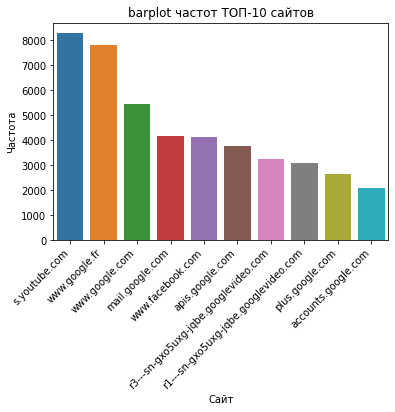

In [23]:
df = pd.DataFrame([top10_freqs, top10_sites], index=["freqs","sites"]).T
df["freqs"] = df[["freqs"]].astype('int')
ax = sns.barplot(data=df,x="sites",y="freqs")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_xlabel("Сайт")
ax.set_ylabel("Частота")
ax.set_title("barplot частот ТОП-10 сайтов")
plt.show()

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [24]:
train_data_10users["session_timespan"].median()

37.0

**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [25]:
train_data_10users["day_of_week"].median()

2.0

**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [26]:
train_data_150users["start_hour"].median()

13.0

**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [27]:
train_data_150users["#unique_sites"].median()

7.0

## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

>  ### Решение

Можно предположить, что разные пользователи имеют разную манеру сёрфинга. Эта манера должна отражатсья в интервалах между запросами страниц. Например, после поиска в поисковике - кто-то открывает сразу несколько найденных поисковой системой страниц и только потом по очереди их читает, а кто-то открывает и читает по одной. Другой пример: некоторые пользователи могут чаще посещать странички с длинными статьями, а кто-то - с короткими. Итак, можно предположить, что интервалы между запросами у разных пользователей распределены по разному. Поэтому попробуем добавить признаки, описывающие это распределение.

Выберем несколько разных признаков, и при обучении посмотрим как будет вести себя модель с разными сочетаниями синтетических признаков.

Очевидными кандидатами на роль статистики интервалов выступают выборочное среднее и среднеквадратичное отклонение для интервалов в сессии. Для подбора других признаков построим график "ящик с усами" для интервалов (признаки "time_diffxx")

In [28]:
import re

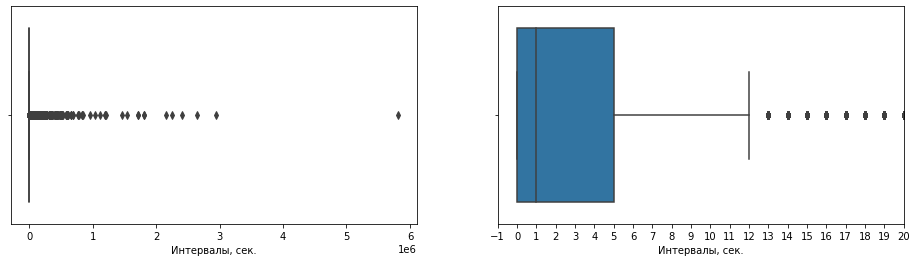

Квантили (всего значений: 126549):
	максисмум = 5812677.00
	уровня 0.99 = 705.04
	уровня 0.95 =  88.00


In [29]:
tcols = [col for col in train_data_10users.columns if re.match(r"^time_diff[0-9]+$", col)]
df = train_data_10users[tcols].to_numpy().ravel()


plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
ax = sns.boxplot(x=df)
ax.set_xlabel("Интервалы, сек.")

plt.subplot(1,2,2)
ax = sns.boxplot(x=df)
ax.set_xlim(-1,20)
ax.set_xticks(range(-1,21))
ax.set_xlabel("Интервалы, сек.")

plt.show()

print(f"Квантили (всего значений: {len(df)}):")
print(f"\tмаксисмум = {np.quantile(df, q=1):>6.2f}")
print(f"\tуровня 0.99 = {np.quantile(df, q=.99):>6.2f}")
print(f"\tуровня 0.95 = {np.quantile(df, q=.95):>6.2f}")

Из boxplot-а видно, что основная масса интервалов сконцентрирована у 0 (99% интервалов не превышают 702 секунд). Но выбросы достигают существенно больших величин относительно величин большинства интервалов. Можно предположить, что интервалы с большими значениями соответствуют моментам неактивности пользователя, т.е. попадание в наши "оценочные" сессии границ "реальных" сессий.

В этом предположении получается, что интервалы короче некоторого порога (вероятно для каждого пользователя этот порог свой) характеризуют "манеру сёрфинга" пользователя, а интервалы длиннее порогового значения - отражают периоды неактивности пользователя, и характеризуют его "график сёрфинга".

Поэтому помимо среднего по всем интервалам сессии, посчитаем статистики для значений короче порога и статистики для значений длиннее порога. На текущий момент остановимся на пороге равном квантилю уровня 0.99 для всех интервалов по всем сессиям обучающего датасета.

При этом считать будем помимо среднего и среднего квадратичного отклонения ещё и медиану и медианное абсолютное отклонение.

Другое соображение - большое количество нулевых интервалов. Если предположить что нулевой интервал - это не запрос пользователя, а автоматические запросы в коде посещаемых пользователем страниц (например, счётчики, рекламные банеры и т.п.) - то учёт нулевых интервалов будет зашумлять информацию о "манере сёрфинга". Поэтому добавим ещё статистики для интервалов без нулевых значений. 


Итого, мы сформируем следующие "интервальные" признаки:

    1) среднее для всех интервалов сессии
    2) медиана для всех интервалов сессии
    3) среднее квадратичное отклонение для всех интервалов сессии
    4) медианное абсолютное отклонение для всех интервалов сессии
    5-8) те же признаки для интервалов короче порогового значения
    9-12) те же признаки для интервалов короче порогового значения и больших нуля
    13-16) те же признаки для интервалов длиннее порогового значения

Дополнительно, добавим следующие признаки:

    17) максимальный интервал в сессии;
    18) квантиль уровня 0.95 для интервалов сессии;
    19) количество нулевых интервалов в сессии.

Перейдём к признакам на основе посещённых сайтов. 

Для начала считаем частотный словарь, построим датафрейм сайтов для дальнейшего подбора признаков.

In [30]:
with open(os.path.join(PATH_TO_DATA, "site_freq_10users.pkl"), "rb") as file:
    frd = pickle.load(file)
sites, ids = list(zip(*sorted(frd.items(), key=lambda x: x[1][1], reverse=True )))
ids, freqs = list(zip(*ids))
sites = pd.DataFrame([sites,freqs], index=["url","freq"], columns=ids).T

Проверим наличие среди url ip-адресов:

In [31]:
ipv4 = r"^(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)$"
sites[sites.url.str.match(ipv4)]

,url,freq
185,160.92.123.193,91
372,193.164.196.60,43
373,193.164.196.40,43
382,193.164.197.50,42
390,193.164.197.40,41
400,193.164.197.60,40
406,193.164.196.50,39
413,193.164.196.30,38
425,193.164.197.30,37
507,85.17.77.13,28


In [32]:
ipv6 = r"^\s*((([0-9A-Fa-f]{1,4}:){7}([0-9A-Fa-f]{1,4}|:))|(([0-9A-Fa-f]{1,4}:){6}(:[0-9A-Fa-f]{1,4}|((25[0-5]|2[0-4]\d|1\d\d|[1-9]?\d)(\.(25[0-5]|2[0-4]\d|1\d\d|[1-9]?\d)){3})|:))|(([0-9A-Fa-f]{1,4}:){5}(((:[0-9A-Fa-f]{1,4}){1,2})|:((25[0-5]|2[0-4]\d|1\d\d|[1-9]?\d)(\.(25[0-5]|2[0-4]\d|1\d\d|[1-9]?\d)){3})|:))|(([0-9A-Fa-f]{1,4}:){4}(((:[0-9A-Fa-f]{1,4}){1,3})|((:[0-9A-Fa-f]{1,4})?:((25[0-5]|2[0-4]\d|1\d\d|[1-9]?\d)(\.(25[0-5]|2[0-4]\d|1\d\d|[1-9]?\d)){3}))|:))|(([0-9A-Fa-f]{1,4}:){3}(((:[0-9A-Fa-f]{1,4}){1,4})|((:[0-9A-Fa-f]{1,4}){0,2}:((25[0-5]|2[0-4]\d|1\d\d|[1-9]?\d)(\.(25[0-5]|2[0-4]\d|1\d\d|[1-9]?\d)){3}))|:))|(([0-9A-Fa-f]{1,4}:){2}(((:[0-9A-Fa-f]{1,4}){1,5})|((:[0-9A-Fa-f]{1,4}){0,3}:((25[0-5]|2[0-4]\d|1\d\d|[1-9]?\d)(\.(25[0-5]|2[0-4]\d|1\d\d|[1-9]?\d)){3}))|:))|(([0-9A-Fa-f]{1,4}:){1}(((:[0-9A-Fa-f]{1,4}){1,6})|((:[0-9A-Fa-f]{1,4}){0,4}:((25[0-5]|2[0-4]\d|1\d\d|[1-9]?\d)(\.(25[0-5]|2[0-4]\d|1\d\d|[1-9]?\d)){3}))|:))|(:(((:[0-9A-Fa-f]{1,4}){1,7})|((:[0-9A-Fa-f]{1,4}){0,5}:((25[0-5]|2[0-4]\d|1\d\d|[1-9]?\d)(\.(25[0-5]|2[0-4]\d|1\d\d|[1-9]?\d)){3}))|:)))(%.+)?\s*$"
sites[sites.url.str.match(ipv6)]

,url,freq


Обращение к ресурсам Интернет по IP довольно редкая ситуация, поэтому можно предположить что периодические обращения по IP будут характеризовать пользователей. Проверим это:

In [33]:
ip_ids = sites[(sites.url.str.match(ipv4)) | (sites.url.str.match(ipv6))].index.to_list()
scols = [col for col in train_data_10users.columns if re.match(r"^site[0-9]+$", col)]

df = train_data_10users.copy()
df["#ips"] = train_data_10users[scols][ train_data_10users[scols].isin(ip_ids) ].count(axis=1)
df[["#ips","target"]].groupby("target").sum()

,#ips
target,
Ashley,0
Avril,304
Bill,0
Bob,28
Dick,0
Ed,0
John,91
Lindsey,2
Mary-Kate,19


Видно что число обращений к IP-адресам разное у разных пользователей, т.е. этот признак "захватывает" часть информации о пользователе.

Далее, предположим что пользователи могут обращаться к сайтам в других странах, и "профиль" таких запросов будет отличаться. Соберём информацию по TLD URL и частоту их встречаемости:

In [34]:
sites["tld"] = sites.loc[~sites.index.isin(ip_ids), "url"].apply(lambda x: x.split('.')[-1])
tldfr = sites.groupby("tld")["freq"].sum()
tldfr.sort_values(ascending=False)/tldfr.sum()

tld
com    0.739528
fr     0.151381
net    0.059159
org    0.032134
dz     0.003040
         ...   
tt     0.000007
pf     0.000007
kr     0.000007
cx     0.000007
am     0.000007
Name: freq, Length: 64, dtype: float64

Как видим, 98% URL в датасете принадлежат всего 4-м TLD (международным .com, .org, .net, и национальному .fr). Т.к. 
часто встречающиеся домены/TLD характеризуют пользователя в меньшей степени, чем редко встречающиеся, отбросим 4 наиболее частых домена. По TLD посторим "мешок TLD", и посторим дополнительный агрегированный признак - число нечастых TLD в сессии.

По схожим соображениям построим агрегированный признак - число нечастых сайтов. В качестве порога выберем значения квантилей уровня 0.50, 0.75, 0.95 и 0.99 частоты всех сайтов.

Итого, сформируем следующие признаки по сайтам:

    1) число запросов по IP в сессии;
    2) "мешок TLD" для нечастых TLD;
    3) число нечастых TLD в сессии;
    4) число нечастых сайтов в сессии.

Ну и наконец добавим признак для отражения частоты работы пользователя в то или иное время суток. Так как в ночные часы сессий нет, и по соображениям линейной независимости, ограничимся тремя признаками:
 - утренняя сессия: 1 если час начала работы с 06 до 11, иначе 0
 - дневная сессия: 1 если час начала работы с 12 до 17, иначе 0
 - вечерняя сессия: 1 если час начала работы с 18 до 23, иначе 0

In [35]:
def feature_engineering(df_in, site_freq_path, tdiff_boundary=None):

    df_out = pd.DataFrame(index=df_in.index)

    # признаки для tdiff
    tcols = [col for col in df_in.columns if re.match(r"^time_diff[0-9]+$", col)]
    tdiff_boundary = tdiff_boundary or np.quantile(
        df_in[tcols].to_numpy().ravel(), 0.99
    )

    prefix = "tdiff_all"
    dft = df_in[tcols]
    df_out[f"{prefix}_mean"] = dft.mean(axis=1)
    df_out[f"{prefix}_median"] = dft.median(axis=1)
    df_out[f"{prefix}_std"] = dft.std(axis=1)
    df_out[f"{prefix}_mad"] = dft.apply(
        lambda x: abs(x - df_out[f"{prefix}_median"])
    ).median(axis=1)

    prefix = "tdiff_short"
    dft = df_in[tcols][df_in[tcols] <= tdiff_boundary]
    dft.loc[dft.isna().all(axis=1)] = 0
    df_out[f"{prefix}_mean"] = dft.mean(axis=1)
    df_out[f"{prefix}_median"] = dft.median(axis=1)
    df_out[f"{prefix}_std"] = dft.std(axis=1).fillna(0)
    df_out[f"{prefix}_mad"] = dft.apply(
        lambda x: abs(x - df_out[f"{prefix}_median"])
    ).median(axis=1)

    prefix = "tdiff_short_positive"
    dft = df_in[tcols][(df_in[tcols] > 0) & (df_in[tcols] <= tdiff_boundary)]
    dft.loc[dft.isna().all(axis=1)] = 0
    df_out[f"{prefix}_mean"] = dft.mean(axis=1)
    df_out[f"{prefix}_median"] = dft.median(axis=1)
    df_out[f"{prefix}_std"] = dft.std(axis=1).fillna(0)
    df_out[f"{prefix}_mad"] = dft.apply(
        lambda x: abs(x - df_out[f"{prefix}_median"])
    ).median(axis=1)

    prefix = "tdiff_long"
    dft = df_in[tcols][df_in[tcols] > tdiff_boundary]
    dft.loc[dft.isna().all(axis=1)] = 0
    df_out[f"{prefix}_mean"] = dft.mean(axis=1)
    df_out[f"{prefix}_median"] = dft.median(axis=1)
    df_out[f"{prefix}_std"] = dft.std(axis=1).fillna(0)
    df_out[f"{prefix}_mad"] = dft.apply(
        lambda x: abs(x - df_out[f"{prefix}_median"])
    ).median(axis=1)

    df_out["tdiff_max"] = df_in[tcols].max(axis=1)
    df_out["tdiff_.95"] = df_in[tcols].quantile(0.95, axis=1)
    df_out["tdiff_#0"] = (df_in[tcols] == 0).sum(axis=1)

    # признаки для site
    scols = [col for col in df_in.columns if re.match(r"^site[0-9]+$", col)]

    with open(site_freq_path, "rb") as file:
        frd = pickle.load(file)

    sites, ids = list(zip(*sorted(frd.items(), key=lambda x: x[1][1], reverse=True)))
    ids, freqs = list(zip(*ids))
    sites = pd.DataFrame([sites, freqs], index=["url", "freq"], columns=ids).T

    ipv4 = r"^(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)$"
    ipv6 = r"^\s*((([0-9A-Fa-f]{1,4}:){7}([0-9A-Fa-f]{1,4}|:))|(([0-9A-Fa-f]{1,4}:){6}(:[0-9A-Fa-f]{1,4}|((25[0-5]|2[0-4]\d|1\d\d|[1-9]?\d)(\.(25[0-5]|2[0-4]\d|1\d\d|[1-9]?\d)){3})|:))|(([0-9A-Fa-f]{1,4}:){5}(((:[0-9A-Fa-f]{1,4}){1,2})|:((25[0-5]|2[0-4]\d|1\d\d|[1-9]?\d)(\.(25[0-5]|2[0-4]\d|1\d\d|[1-9]?\d)){3})|:))|(([0-9A-Fa-f]{1,4}:){4}(((:[0-9A-Fa-f]{1,4}){1,3})|((:[0-9A-Fa-f]{1,4})?:((25[0-5]|2[0-4]\d|1\d\d|[1-9]?\d)(\.(25[0-5]|2[0-4]\d|1\d\d|[1-9]?\d)){3}))|:))|(([0-9A-Fa-f]{1,4}:){3}(((:[0-9A-Fa-f]{1,4}){1,4})|((:[0-9A-Fa-f]{1,4}){0,2}:((25[0-5]|2[0-4]\d|1\d\d|[1-9]?\d)(\.(25[0-5]|2[0-4]\d|1\d\d|[1-9]?\d)){3}))|:))|(([0-9A-Fa-f]{1,4}:){2}(((:[0-9A-Fa-f]{1,4}){1,5})|((:[0-9A-Fa-f]{1,4}){0,3}:((25[0-5]|2[0-4]\d|1\d\d|[1-9]?\d)(\.(25[0-5]|2[0-4]\d|1\d\d|[1-9]?\d)){3}))|:))|(([0-9A-Fa-f]{1,4}:){1}(((:[0-9A-Fa-f]{1,4}){1,6})|((:[0-9A-Fa-f]{1,4}){0,4}:((25[0-5]|2[0-4]\d|1\d\d|[1-9]?\d)(\.(25[0-5]|2[0-4]\d|1\d\d|[1-9]?\d)){3}))|:))|(:(((:[0-9A-Fa-f]{1,4}){1,7})|((:[0-9A-Fa-f]{1,4}){0,5}:((25[0-5]|2[0-4]\d|1\d\d|[1-9]?\d)(\.(25[0-5]|2[0-4]\d|1\d\d|[1-9]?\d)){3}))|:)))(%.+)?\s*$"
    ip_ids = sites[
        (sites.url.str.match(ipv4)) | (sites.url.str.match(ipv6))
    ].index.to_list()
    df_out["#ips"] = df_in[scols].isin(ip_ids).sum(axis=1)

    sites["tld"] = sites.loc[~sites.index.isin(ip_ids), "url"].apply(
        lambda x: x.split(".")[-1]
    )
    tldfr = sites.groupby("tld")["freq"].sum()
    uncommon_tlds = tldfr.sort_values(ascending=False)[4:].index.to_list()
    mapper = {i[0]: i[1]["tld"] for i in sites.iterrows()}
    tld_sites = df_in[scols].applymap(lambda x: mapper[x] if x in mapper else 0)
    for tld in uncommon_tlds:
        df_out[f"#tld_{tld}"] = (tld_sites == tld).sum(axis=1)

    tldcols = [col for col in df_out.columns if re.match(r"^#tld_.+$", col)]
    df_out["#uncommon_tlds"] = df_out[tldcols].sum(axis=1)

    for q in [ .5, .75, .95, .99, 1 ]:
        uncommon_ids = sites[sites.freq < np.quantile(sites.freq ,q=q)].index.to_list()
        df_out[f"#uncommon_sites_{q}"] = df_in[scols].isin(uncommon_ids).sum(axis=1)
    
    df_out[f"session_morning"] = (
        (df_in["start_hour"] >= 6) & (df_in["start_hour"] <= 11)
    ).astype("int")
    df_out[f"session_noon"] = (
        (df_in["start_hour"] >= 12) & (df_in["start_hour"] <= 17)
    ).astype("int")
    df_out[f"session_evening"] = (
        (df_in["start_hour"] >= 18) & (df_in["start_hour"] <= 23)
    ).astype("int")

    return df_out

In [36]:
new_features_10users = feature_engineering(train_data_10users,
                                           os.path.join(PATH_TO_DATA, "site_freq_10users.pkl"))

In [37]:
new_features_150users = feature_engineering(train_data_150users,
                                            os.path.join(PATH_TO_DATA, "site_freq_150users.pkl"))

**14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [38]:
from scipy import stats as st
df = train_data_10users.join(new_features_10users)

Для начала построим столбчатые диаграммы для среднего и медианы. В seaborn столбчатая диаграмма строится с расчётом доверительного интервала методом бутстрапа. Дополнительно отобразим выборочное среднее и его доверительный t-интервал для соответствующей статистики по всем пользователям (красная сплошная и красные пунктирные линии)

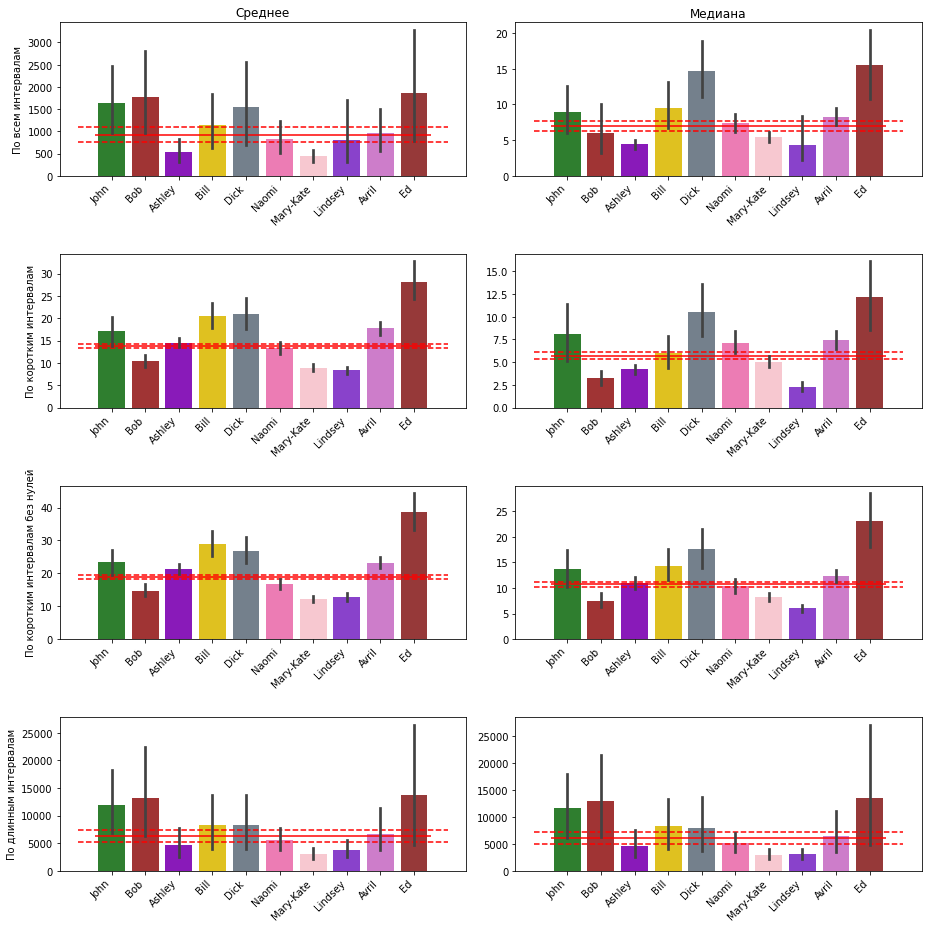

In [39]:
stats = ["mean", "median"]
subsets = ["all", "short", "short_positive", "long"]

cols = ["Среднее", "Медиана"]
rows = [
    "По всем интервалам",
    "По коротким интервалам",
    "По коротким интервалам без нулей",
    "По длинным интервалам",
]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(13, 13))

for row, subset in enumerate(subsets):
    for col, stat in enumerate(stats):
        stname = "tdiff_" + subset + "_" + stat
        ax = sns.barplot(
            data=df, x="target", y=stname, palette=color_dic, ax=axes[row, col]
        )
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
        ax.set_xlabel("")
        ax.set_ylabel("")

        mean = df[stname].mean()
        ci = st.t.interval(
            alpha=0.95, df=len(df[stname]) - 1, loc=mean, scale=st.sem(df[stname])
        )
        ax.hlines(mean, *ax.get_xlim(), color="red")
        ax.hlines(ci, *ax.get_xlim(), color="red", linestyles="dashed")

for ax, col in zip(axes[0], cols):
    ax.set_title(col)
for ax, row in zip(axes[:, 0], rows):
    ax.set_ylabel(row, rotation=90)

fig.tight_layout()
plt.show()

На графиках отображено среднее значение статистик интервалов в сессиях для каждого пользователя. В целом графики согласуются с предположениями, сделанными при синтезе этих признаков. Например, если сравнивать статистики, посчитанные для всех интервалов в сессии, то ожидаемо медиана лучше характеризует пользователя чем среднее из-за большого количество выбросов.  Действительно, если посчитать количество пользователей, у которых среднее статистики статистически значимо отличается от среднего по генеральной совокупности (по всем интервалам всего датасета), то для среднего таких пользователей всего два, а для медианы - четыре.

Далее, выбор только коротких интервалов для подсчёта статистики заметно лучше характеризует пользователей: количество пользователей со статистически значимым отличием среднего от среднего по генеральной совокупности интервалов - восемь из 10ти. При этом визуально среднее и медиана показывают уже сопоставимое качество, возможно даже что статистика среднего лучше различает пользователей чем статистика медианы.

Статистики учитывающие только кроткие интервалы без нулевых интервалов: для этих статистик справедливы те же выводы, за исключением того что в этим случае преимущество среднего перед медианой выражено ярче.

И наконец статистики, учитывающие только длинные интервалы плохо характеризуют пользователя - статистики для 9 пользователей из 10 отличатся от среднего по генеральной совокупности несущественно (т.к. доверительные интервалы пользователя и генеральной совокупности пересекаются). Возможно это связано с неудачным выбором порога, или недостаточным количеством длинных интервалов для захвата закономерности.

Посмотрим таким же образом диаграммы для статистик среднеквадратичное отклонение и медианное абсолютное отклонение.

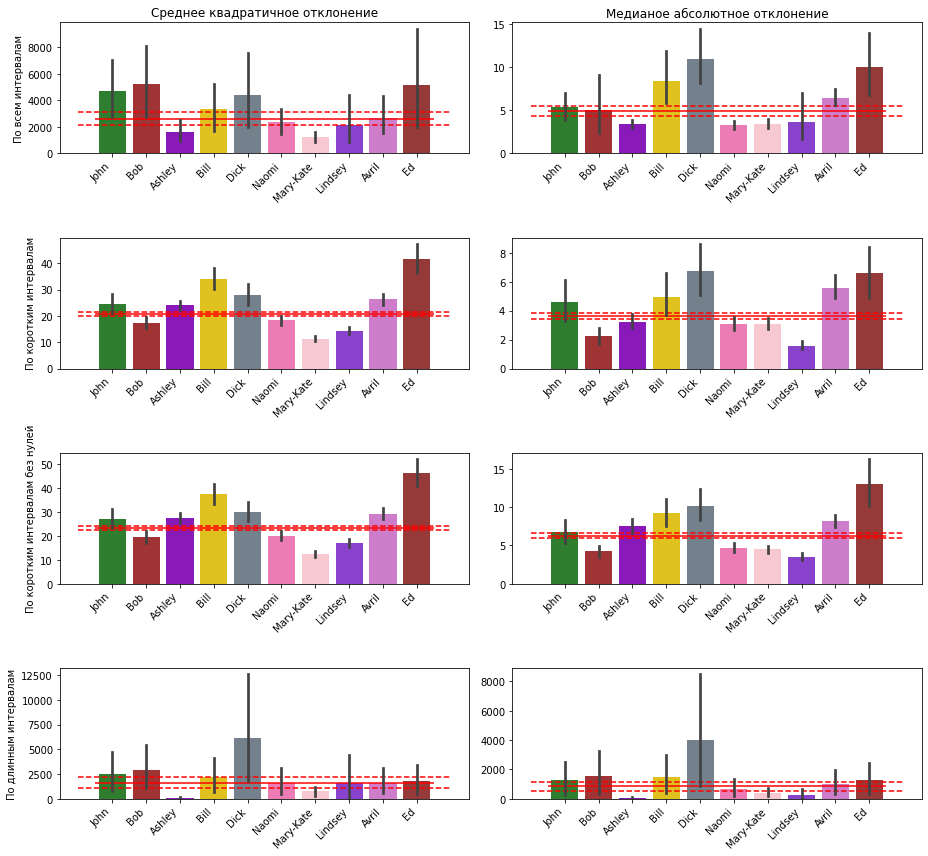

In [40]:
stats = ["std", "mad"]
subsets = ["all", "short", "short_positive", "long"]

cols = ["Среднее квадратичное отклонение", "Медианое абсолютное отклонение"]
rows = [
    "По всем интервалам",
    "По коротким интервалам",
    "По коротким интервалам без нулей",
    "По длинным интервалам",
]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(13, 12))

for row, subset in enumerate(subsets):
    for col, stat in enumerate(stats):
        stname = "tdiff_" + subset + "_" + stat
        ax = sns.barplot(
            data=df, x="target", y=stname, palette=color_dic, ax=axes[row, col]
        )
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
        ax.set_xlabel("")
        ax.set_ylabel("")

        mean = df[stname].mean()
        ci = st.t.interval(
            alpha=0.95, df=len(df[stname]) - 1, loc=mean, scale=st.sem(df[stname])
        )
        ax.hlines(mean, *ax.get_xlim(), color="red")
        ax.hlines(ci, *ax.get_xlim(), color="red", linestyles="dashed")

for ax, col in zip(axes[0], cols):
    ax.set_title(col)
for ax, row in zip(axes[:, 0], rows):
    ax.set_ylabel(row, rotation=90)

fig.tight_layout()
plt.show()

Для этих статистик картина аналогичная статистикам среднего и медианы. Но для длинных сессий статистики отклонений лучше характеризуют пользователей чем статистики средних

Проверим как характеризуют пользователей оставшиеся три интервальных признака.

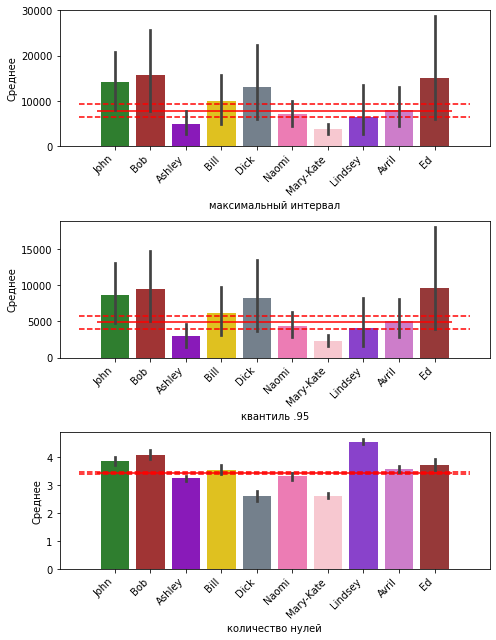

In [41]:
stats = ["tdiff_max","tdiff_.95", "tdiff_#0"]
labels = ["максимальный интервал","квантиль .95","количество нулей"]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 9))
for idx, (stat,label) in enumerate(zip(stats,labels)):
    ax = sns.barplot(data=df, x="target", y=stat, palette=color_dic, ax=axes[idx])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_xlabel(label)
    ax.set_ylabel("Среднее")

    mean = df[stat].mean()
    ci = st.t.interval(alpha=0.95, df=len(df[stat])-1, loc=mean, scale=st.sem(df[stat]))
    ax.hlines( df[stat].mean(), *ax.get_xlim(), color="red" )
    ax.hlines( ci, *ax.get_xlim(), color="red", linestyles="dashed" )

fig.tight_layout()
plt.show()

Последний график перерисуем в увеличеном масштабе.

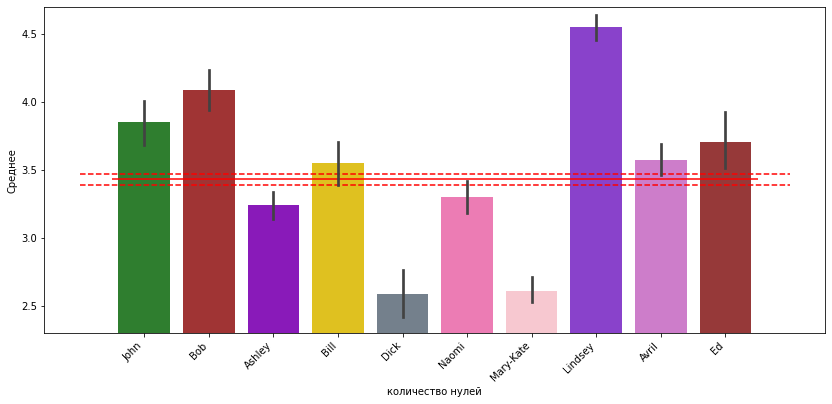

In [42]:
stat = "tdiff_#0"
label = "количество нулей"

plt.figure(figsize=(14, 6))
ax = sns.barplot(data=df, x="target", y=stat, palette=color_dic)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_xlabel(label)
ax.set_ylabel("Среднее")

mean = df[stat].mean()
ci = st.t.interval(alpha=0.95, df=len(df[stat])-1, loc=mean, scale=st.sem(df[stat]))
ax.hlines( df[stat].mean(), *ax.get_xlim(), color="red" )
ax.hlines( ci, *ax.get_xlim(), color="red", linestyles="dashed" )

ax.set_ylim(2.3,4.7)

plt.show()

Статистики максимального интервала в сессии и квантиля уровня 0.95 слабо характеризуют пользователя (3 из 10 имеют статистически значимое отклонение от среднего в генеральной совокупности).

Статистика количества нулей в сессии характеризует пользователей достаточно хорошо - у 7 из 10 пользоватлей среднее существенно отличается.

Теперь посмотрим как характеризуется пользователь количеством  нестандартных сайтов в сессии.

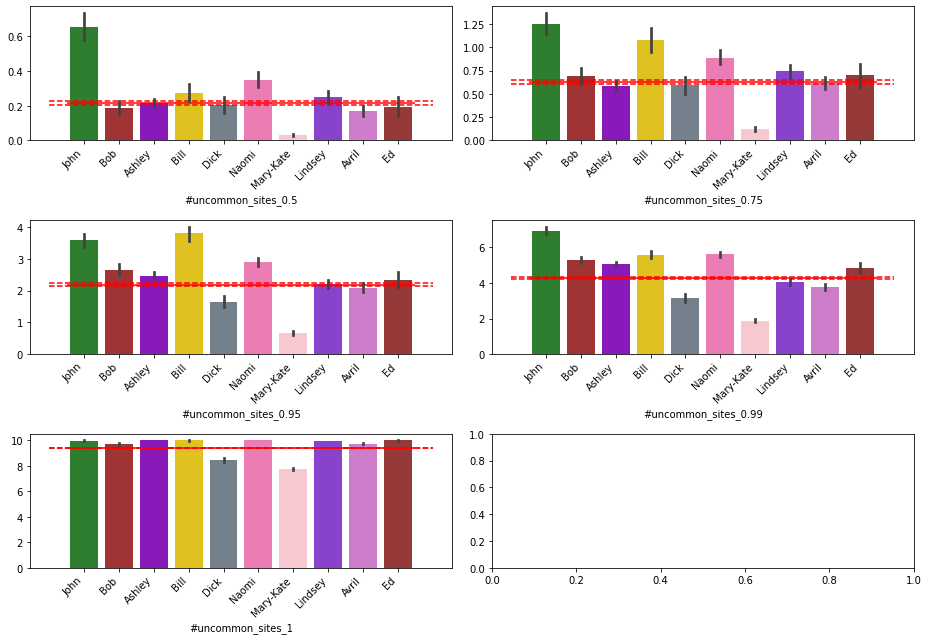

In [43]:
cols = [ c for c in df.columns if re.match(r"#uncommon_sites_.*",c)]

rows = int(np.ceil(len(cols)/2))
fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(13, 3*rows))
for idx, col in enumerate(cols):
    ax = sns.barplot(data=df, x="target", y=col, palette=color_dic, ax=axes.ravel()[idx])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_xlabel(col)
    ax.set_ylabel("")

    mean = df[col].mean()
    ci = st.t.interval(alpha=0.95, df=len(df[col])-1, loc=mean, scale=st.sem(df[col]))
    ax.hlines( df[col].mean(), *ax.get_xlim(), color="red" )
    ax.hlines( ci, *ax.get_xlim(), color="red", linestyles="dashed" )

fig.tight_layout()
plt.show()

На основе диаграм заключаем, при выборе порога для частоты "частых" лучше всего работает порог равный .99 квантилю.

И наконец посмотрим как характеризуют пользователя отсавшиеся признаки для сайтов.

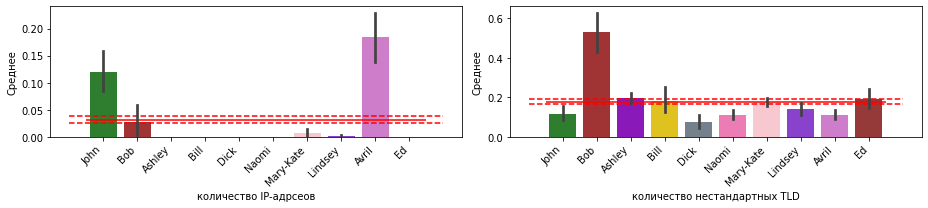

In [44]:
stats = ["#ips", "#uncommon_tlds"]
labels = ["количество IP-адрсеов","количество нестандартных TLD"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 3))
for idx, (stat,label) in enumerate(zip(stats,labels)):
    ax = sns.barplot(data=df, x="target", y=stat, palette=color_dic, ax=axes[idx])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_xlabel(label)
    ax.set_ylabel("Среднее")

    mean = df[stat].mean()
    ci = st.t.interval(alpha=0.95, df=len(df[stat])-1, loc=mean, scale=st.sem(df[stat]))
    ax.hlines( df[stat].mean(), *ax.get_xlim(), color="red" )
    ax.hlines( ci, *ax.get_xlim(), color="red", linestyles="dashed" )

fig.tight_layout()
plt.show()

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [45]:
selected_features_10users = train_data_10users[
    ["session_timespan", "#unique_sites", "start_hour", "day_of_week"]
].join(new_features_10users)

selected_features_150users = train_data_150users[
    ["session_timespan", "#unique_sites", "start_hour", "day_of_week"]
].join(new_features_150users)

In [46]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 